<a href="https://colab.research.google.com/github/tamiresco/IBM/blob/master/Timing_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Introdução

* Feature Selection: teste de hipotese em cada feature
* Modelo: Com os atributos das distribuições da sessao 1 e 2(?) preveremos quando a porcentagem de acerto dos ratos na sessao 7(?)

Envirolment setting up

In [1]:
# basicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import dask as dask
from scipy import stats

# google colab
from google.colab import files

# feature selection
!pip install boruta
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error

# model
import xgboost as xgb

     |████████████████████████████████| 61kB 4.4MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Opening file

In [2]:
dataFrame3 = pd.read_csv('dataFrame3A.csv')#, index_col=['rat'])#.drop(columns=['rat'])
y_append = pd.read_csv('y_append.cvs')#, index_col=['rat'])#.drop(columns=['rat','session'])

### Preprocessing

In [3]:
scaler = StandardScaler()

In [4]:
y_append.drop(index=[15,16], inplace=True)
y_append.drop(columns=['session', 'rat'], inplace=True)

scaler.fit(y_append)
y = scaler.transform(y_append)

y = pd.DataFrame(y).apply(lambda x: 100*round(x,2)).astype('int32')
y = np.array(y)

In [5]:
y_append

,rate success
0,0.704918
1,0.509728
2,0.448029
3,0.673077
4,0.451777
5,0.568966
6,0.441426
7,0.478610
8,0.542923
9,0.378182


In [6]:
# dataFrame3.drop(index=[15,16,17,18,19], inplace=True)
dataFrame3.reset_index(inplace=True)
dataFrame3.drop(columns=['index', 'rat'], inplace=True)
dataFrame3.dropna(axis=1, inplace=True)

scaler.fit(dataFrame3)
X = scaler.transform(dataFrame3)

X = pd.DataFrame(X).applymap(lambda x: 100*round(x,2)).astype('int32') #multiplicando por 100, arredondando e definindo como inteiro: 0.453 = 45 
X = np.array(X) #transformando em np array pq o boruta pede isso

In [7]:
dataFrame3

,T_entropy,T_entropy.1,T_entropy.2,T_entropy.3,T_entropy.4,T_entropy.5,ITI_entropy,ITI_entropy.1,ITI_entropy.2,ITI_entropy.3,ITI_entropy.4,ITI_entropy.5,A_entropy,A_entropy.1,A_entropy.2,A_entropy.3,A_entropy.4,A_entropy.5,B_entropy.1,B_entropy.2,B_entropy.4,C_entropy.1,C_entropy.2,C_entropy.4,D_entropy.1,D_entropy.2,D_entropy.4,F_entropy.1,F_entropy.2,F_entropy.4,E_entrpy,E_entrpy.1,E_entrpy.2,E_entrpy.3,E_entrpy.4,E_entrpy.5,G_entropy.1,G_entropy.2,G_entropy.4,H_entropy.1,H_entropy.2,H_entropy.4,I_entropy.1,I_entropy.2,I_entropy.4,J_entropy.1,J_entropy.2,J_entropy.4
0,0.25,0.37,0.31,0.41,0.41,0.43,1.17,1.23,0.96,1.36,1.05,1.33,0.21,0.28,0.09,0.25,0.23,0.27,1.30,1.10,1.12,1.30,1.10,1.12,1.30,1.10,1.12,1.30,1.10,1.12,0.06,0.00,0.04,0.10,0.12,0.11,1.30,1.10,1.12,1.30,1.10,1.12,1.30,1.10,1.12,1.30,1.10,1.12
1,0.31,0.43,0.41,0.41,0.43,0.42,0.98,0.96,0.78,1.16,1.10,1.16,0.31,0.28,0.20,0.30,0.25,0.22,1.09,0.98,1.11,1.09,0.98,1.11,1.09,0.98,1.11,1.09,0.98,1.11,0.07,0.11,0.11,0.07,0.09,0.10,1.09,0.98,1.11,1.09,0.98,1.11,1.09,0.98,1.11,1.09,0.98,1.11
2,0.08,0.22,0.33,0.33,0.47,0.50,1.39,1.24,0.94,1.01,1.06,1.18,0.01,0.11,0.13,0.15,0.39,0.44,1.23,1.03,1.10,1.23,1.03,1.10,1.23,1.03,1.10,1.23,1.03,1.10,-0.22,-0.05,0.08,0.09,0.11,0.09,1.23,1.03,1.10,1.23,1.03,1.10,1.23,1.03,1.10,1.23,1.03,1.10
3,0.37,0.61,0.46,0.47,0.45,0.63,1.08,1.64,1.20,1.23,1.12,1.34,0.34,0.77,0.38,0.34,0.35,0.67,1.65,1.28,1.19,1.65,1.28,1.19,1.65,1.28,1.19,1.65,1.28,1.19,0.07,0.09,0.11,0.10,0.10,0.10,1.65,1.28,1.19,1.65,1.28,1.19,1.65,1.28,1.19,1.65,1.28,1.19
4,0.20,0.45,0.29,0.30,0.23,0.28,0.89,1.13,1.04,1.07,1.03,1.08,0.16,0.34,0.05,0.07,-0.00,-0.01,1.19,1.13,1.12,1.19,1.13,1.12,1.19,1.13,1.12,1.19,1.13,1.12,0.04,0.11,0.09,0.07,0.04,0.10,1.19,1.13,1.12,1.19,1.13,1.12,1.19,1.13,1.12,1.19,1.13,1.12
5,0.04,0.24,0.26,0.34,0.30,0.42,0.81,0.91,0.84,0.97,1.06,1.09,0.10,0.10,-0.00,0.12,0.03,0.20,1.04,0.96,1.07,1.04,0.96,1.07,1.04,0.96,1.07,1.04,0.96,1.07,-0.12,0.04,0.08,0.10,0.11,0.10,1.04,0.96,1.07,1.04,0.96,1.07,1.04,0.96,1.07,1.04,0.96,1.07
6,0.33,0.47,0.42,0.35,0.39,0.37,0.99,1.01,0.98,0.97,1.04,0.92,0.30,0.38,0.24,0.13,0.20,0.16,1.12,1.05,1.12,1.12,1.05,1.12,1.12,1.05,1.12,1.12,1.05,1.12,0.03,0.10,0.10,0.10,0.10,0.10,1.12,1.05,1.12,1.12,1.05,1.12,1.12,1.05,1.12,1.12,1.05,1.12
7,0.21,0.30,0.42,0.50,0.46,0.48,1.23,1.04,0.94,0.87,0.92,1.06,0.21,0.29,0.39,0.46,0.31,0.36,1.05,0.95,1.08,1.05,0.95,1.08,1.05,0.95,1.08,1.05,0.95,1.08,-0.07,-0.03,0.10,0.12,0.11,0.10,1.05,0.95,1.08,1.05,0.95,1.08,1.05,0.95,1.08,1.05,0.95,1.08
8,0.42,0.47,0.48,0.43,0.44,0.38,1.08,1.15,1.18,1.01,1.03,1.00,0.34,0.44,0.46,0.28,0.28,0.17,1.24,1.21,1.15,1.24,1.21,1.15,1.24,1.21,1.15,1.24,1.21,1.15,0.09,0.11,0.12,0.11,0.11,0.12,1.24,1.21,1.15,1.24,1.21,1.15,1.24,1.21,1.15,1.24,1.21,1.15
9,0.33,0.44,0.53,0.48,0.45,0.39,1.22,1.08,1.15,0.96,0.93,0.97,0.33,0.29,0.41,0.31,0.27,0.19,1.14,1.18,1.00,1.14,1.18,1.00,1.14,1.18,1.00,1.14,1.18,1.00,0.05,0.12,0.11,0.10,0.09,0.09,1.14,1.18,1.00,1.14,1.18,1.00,1.14,1.18,1.00,1.14,1.18,1.00


### Feature Selection

Boruta

In [ ]:
# Iniciando modelo
rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight= 'balanced_subsample' , max_depth=10) 
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1, max_iter = 50, perc = 90) #TO DO entender melhor 

# aplicando aos dados
boruta_selector.fit(X, y)

# colunas aprovadas
# X.columns[boruta.support_]
# X.columns[boruta.upport_weak_]

# fazendo novo X
# X_new = X.columns[boruta.support_]

SelectKBest

In [8]:
# Iniciando modelo
selector = SelectKBest(f_regression, k=2)

# Aplicando aos dados e fazendo novo X
X_new = selector.fit_transform(X, y)

# pvalue de cada variavel
p_values = selector.pvalues_
p_values

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.00752797, 0.03811127, 0.3936023 , 0.38066771, 0.59754209,
       0.48877302, 0.12692413, 0.52157358, 0.88159146, 0.38069812,
       0.78425462, 0.14739742, 0.42474195, 0.28810042, 0.94973489,
       0.91178111, 0.48061335, 0.94263393, 0.17207055, 0.25238281,
       0.09197215, 0.17207055, 0.25238281, 0.09197215, 0.17207055,
       0.25238281, 0.09197215, 0.17207055, 0.25238281, 0.09197215,
       0.04857289, 0.10952896, 0.28140671, 0.29078502, 0.32609779,
       0.18385771, 0.17207055, 0.25238281, 0.09197215, 0.17207055,
       0.25238281, 0.09197215, 0.17207055, 0.25238281, 0.09197215,
       0.17207055, 0.25238281, 0.09197215])

In [ ]:
# Iniciando modelo
mod = sm.OLS(y,X)

# Aplicando aos dados
fii = mod.fit()

# pvalue de cada variavel
p_values = fii.summary2().tables[1]['P>|t|']
p_values

### Model

Treino

In [10]:
# separando os dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.15)

# treinando regressor
xgbr = xgb.XGBRegressor(verbosity=0)  # (?) (n_estimators=1000, learning_rate=0.05, n_jobs=4)
xgbr.fit(X_train, y_train) # (?) (X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False) 
score = xgbr.score(X_train, y_train)   
print("Training score: ", score) 

Training score:  0.8447524009954652


Validação 
*   *The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).*

In [11]:
# cross validataion com cv = 5 e cv = Kfold (para comparar)
scores = cross_val_score(xgbr, X_train, y_train, cv=5, scoring = "neg_mean_absolute_error")
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold , scoring = "neg_mean_absolute_error")
print("Kfold CV average score: %.2f" % kf_cv_scores.mean())

Mean cross-validation score: -105.28
Kfold CV average score: -101.52


Teste

r2: -1.43
r2: -0.72


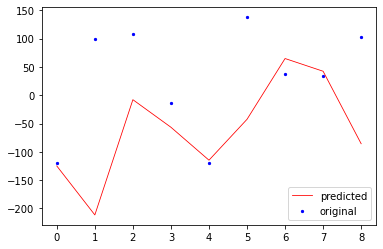

In [12]:
# testando regressor
y_pred = xgbr.predict(X_test) # (?) nao deveria fazer com um X_valid ate eu ter certeza q é a ultima alteracao q estou fazendo no modelo
r2 = r2_score(y_test, y_pred)
print("r2: %.2f" % r2)
print("r2: %.2f" % (r2*(1/2.0)))

# graficos
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()